In [1]:
import pickle
from collections import Counter

import pandas as pd
import numpy as np
import pybedtools as pybt
import conorm

import matplotlib.pyplot as plt
import seaborn as sns
from mycolorpy import colorlist as mcp
from matplotlib_venn import venn2,venn3
from matplotlib import gridspec
from matplotlib.lines import Line2D

import networkx as nx
sns.set(style="ticks", font_scale=2)

Text(0.5, 1.0, 'HiChIP Loops (e5)')

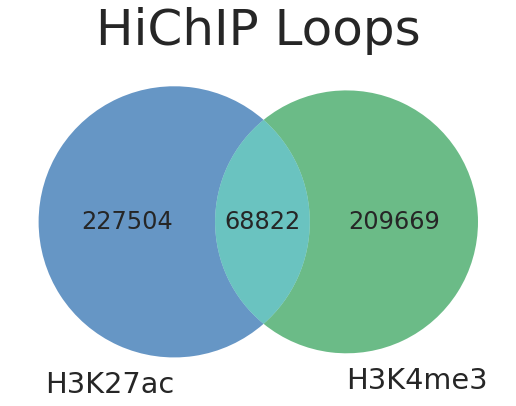

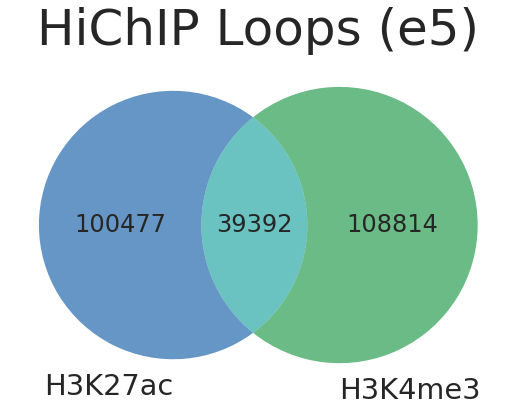

In [5]:
sns.set(style="ticks", font_scale=2)

H3K27ac = pd.read_table('data/H3K27ac_Loops.bedpe', names=['Chr1', 'Start1', 'End1','Chr2', 'Start2', 'End2', 'Name', 'PET', 'PADJ'])

H3K4me3 = pd.read_table('data/H3K4me3_Loops.bedpe', names=['Chr1', 'Start1', 'End1','Chr2', 'Start2', 'End2', 'Name', 'PET', 'PADJ'])



fig = plt.figure(figsize=[9,9])

venn2((set(H3K27ac.loc[H3K27ac['PADJ'] > 2, 'Name']), set(H3K4me3.loc[H3K4me3['PADJ'] > 2, 'Name'])), set_labels=('H3K27ac', 'H3K4me3'), set_colors=('#01509f' ,'#098e37'), alpha=0.6)
plt.title('HiChIP Loops', fontsize=50)


#fig.savefig('../plots/HiChIPvenn.pdf', bbox_inches ="tight",  pad_inches = 1 )


plt.figure(figsize=[9,9])

venn2((set(H3K27ac.loc[H3K27ac['PADJ'] > 5, 'Name']), set(H3K4me3.loc[H3K4me3['PADJ'] > 5, 'Name'])), set_labels=('H3K27ac', 'H3K4me3'), set_colors=('#01509f' ,'#098e37'), alpha=0.6)
plt.title('HiChIP Loops (e5)', fontsize=50)

In [3]:
!Rscript GI.R.edges.r -i <(cut -f1-7 data/NEW_H3K27ac_16h.tmm.bedpe) -b data/CRE.bed -o data/H3K27ac.edges.CRE.tsv
!Rscript GI.R.edges.r -i <(cut -f1-7 data/NEW_H3K4me3_16h.tmm.bedpe) -b data/CRE.bed -o data/H3K4me3.edges.CRE.tsv

No 'score' column found; setting counts to 1.
Warning message:
In file(resource) :
  using 'raw = TRUE' because '/dev/fd/63' is a fifo or pipe
Annotating with cre ...
Warning message:
In annotateInteractions(pet, annotation.features) :
  Some features contain duplicate IDs which will result in duplicate annotations
       category  count
1 distal-distal  50573
2    distal-cre 154504
3       cre-cre  91249
None
No 'score' column found; setting counts to 1.
Warning message:
In file(resource) :
  using 'raw = TRUE' because '/dev/fd/63' is a fifo or pipe
Annotating with cre ...
Warning message:
In annotateInteractions(pet, annotation.features) :
  Some features contain duplicate IDs which will result in duplicate annotations
       category  count
1 distal-distal  27028
2    distal-cre 161709
3       cre-cre  89754
None


In [4]:
MAPty = pickle.load(open('../data/pickle/MAPty.p', 'rb'))
Counter(MAPty.values())

Counter({'Enhancer': 58646, 'Promoter': 19105})

In [5]:
GS = {}
for s in ['H3K27ac', 'H3K4me3']:

    interactions = f"../January-23/data/{s}.edges.CRE.tsv"
    df = pd.read_table(interactions)

    GS[s] = nx.Graph()

    for i, row in df.iterrows():

        # >>> 1 >>>
        if row["cre.id1"].find("['") != -1:        
            s1 = row["cre.id1"].replace("['", "")
            s1 = s1.replace("']", "")
            s1 = s1.split("', '")
        else:
            s1 = [row["cre.id1"]]

        if row["cre.id2"].find("['") != -1:
            s2 = row["cre.id2"].replace("['", "")
            s2 = s2.replace("']", "")
            s2 = s2.split("', '")
        else:
            s2 = [row["cre.id2"]]

        # <<< 1 <<<

        # >>> 2 (3) >>>

        for s1_ in s1:
            for s2_ in s2:
                if s1_ == s2_:
                    continue
                nc1 = MAPty[s1_]
                GS[s].add_node(s1_, nodeClass=nc1)
                nc2 = MAPty[s2_]
                GS[s].add_node(s2_, nodeClass=nc2)
                
                GS[s].add_edge(s1_, s2_)


In [6]:
Counter(dict(GS['H3K27ac'].nodes('nodeClass')).values())

Counter({'Promoter': 12232, 'Enhancer': 34375})

In [7]:
Counter(dict(GS['H3K4me3'].nodes('nodeClass')).values())

Counter({'Promoter': 12287, 'Enhancer': 29506})

# The arcs

In [8]:

n = {}
for a, b in GS['H3K27ac'].edges:

    i = MAPty[a]
        
    j = MAPty[b]
    
    if (i, j) in n:
        n[(i,j)] +=1
    elif (j,i) in n:
        n[(j,i)] += 1
    else:
        n[(i,j)] = 1


p = [(k[0], k[1],100*v/sum(n.values()), 'H3K27ac') for k,v in n.items()]


n = {}
for a, b in GS['H3K4me3'].edges:
        
    i = MAPty[a]
        
    j = MAPty[b]
    
    if (i, j) in n:
        n[(i,j)] +=1
    elif (j,i) in n:
        n[(j,i)] += 1
    else:
        n[(i,j)] = 1


p += [(k[0], k[1],100*v/sum(n.values()), 'H3K4me3') for k,v in n.items()]
p

[('Promoter', 'Promoter', 16.06720473791597, 'H3K27ac'),
 ('Promoter', 'Enhancer', 36.41821497571457, 'H3K27ac'),
 ('Enhancer', 'Enhancer', 47.514580286369466, 'H3K27ac'),
 ('Promoter', 'Promoter', 24.597792010635718, 'H3K4me3'),
 ('Promoter', 'Enhancer', 45.52608176207971, 'H3K4me3'),
 ('Enhancer', 'Enhancer', 29.87612622728457, 'H3K4me3')]